# 1.Huấn luyện dữ liệu và lưu thành checkpoint

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu huấn luyện, và tỷ lệ dữ liệu để huấn luyện, còn lại là validate
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w12-01-label',
    'nsm-2023w11-08-label',
    'nsm-2023w11-07-label',
    'nsm-2023w11-06-label',
    #'nsm-2023w09-04-label',
    #'nsm-2023w09-02-label',
    #'nsm-2023w09-01-label',
    #'nsm-2023w06-ssh-02-label',
    #'nsm-2023w07-dos-02-label',
    #'nsm-2023w07-01-label',
]))
# nếu data visualization không hiển thị phần dữ liệu validation thì hạ tỷ lệ train_size_ratio xuống
# đặt để data visualization hiển thị dữ liệu anomaly trên cả 2 tập: train và test
train_size_ratio = 0.7

In [2]:
#@title Nhập tên checkpoint để lưu trữ, trùng với tên file huấn luyện AI Agent testing
checkpoint = '2023W1201'

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-20 11:59:45.345506: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 11:59:47.474623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-20 11:59:47.476032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-20 11:59:47.478672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [23]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
import pandas as pd
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string, evaluate_checkpoint_metric

run, client = common.init_experiment(name='notebook')
client.log_param(run_id=run.info.run_id, key='checkpoint', value=checkpoint)

# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"} # so 100 trong hinh 4d
n_features = 79   #@param {type:"integer"}

# dataset size la tong so flow trong L_source, lay tu cac file csv da duoc gan nhan va chuan hoa
# dataset size = (n_timesteps_in * train_size) + (n_timesteps_in * test_size) = train dataset size + test dataset size

# generate datasets
#train_size= 500 #@param {type:"integer"}    # la 413 trong hinh la kich thuoc bo du lieu dua vao huan luyen
#test_size = 123  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=110 #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))


total_size = int(L_count.sum()['count()']) // n_timesteps_in
train_size = int(total_size * train_size_ratio)
test_size = total_size - train_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('train_size = ', train_size)
print ('test_size = ', test_size)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in))
L_train[Lpadding_features] = 0
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in))
L_test[Lpadding_features] = 0
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

print ('done loading')

(_prepare_read pid=20169) 2023-03-20 12:00:54,299	WARNING file_meta_provider.py:161 -- Expanding 4 path(s). This may be a HIGH LATENCY operation on some cloud storage services. If the specified paths all point to files and never directories, try rerunning this read with `meta_provider=FastFileMetadataProvider()`.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 53.49it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

label  count()
0    0.0   125903
1    1.0    76973

## Data preview

### L_train preview

In [7]:
L_train[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0         0.0      0.964028         0.0          0.0         0.0         0.0   
1         0.0      0.964028         0.0          0.0         0.0         0.0   
2         0.0      0.964028         0.0          0.0         0.0         0.0   
3         0.0      0.964028         0.0          0.0         0.0         0.0   
4         0.0      0.964028         0.0          0.0         0.0         0.0   
...       ...           ...         ...          ...         ...         ...   
141895    1.0      1.000000         0.0          0.0         0.0         0.0   
141896    1.0      1.000000         0.0          0.0         0.0         0.0   
141897    1.0      1.000000         0.0          0.0         0.0         0.0   
141898    1.0      1.000000         0.0          0.0         0.0         0.0   
141899    1.0      1.000000         0.0          0.0         0.0         0.0   

        bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                    0.0             0.0             0.0          0.0   
1                    0.0             0.0             0.0          0.0   
2                    0.0             0.0             0.0          0.0   
3                    0.0             0.0             0.0          0.0   
4                    0.0             0.0             0.0          0.0   
...                  ...             ...             ...          ...   
141895               1.0             1.0             1.0          1.0   
141896               1.0             1.0             1.0          1.0   
141897               1.0             1.0             1.0          1.0   
141898               1.0             1.0             1.0          1.0   
141899               1.0             1.0             1.0          1.0   

        bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0                0.0          0.0          0.0          0.0              0.0   
1                0.0          0.0          0.0          0.0              0.0   
2                0.0          0.0          0.0          0.0              0.0   
3                0.0          0.0          0.0          0.0              0.0   
4                0.0          0.0          0.0          0.0              0.0   
...              ...          ...          ...          ...              ...   
141895           1.0          1.0          1.0          1.0              1.0   
141896           1.0          1.0          1.0          1.0              1.0   
141897           1.0          1.0          1.0          1.0              1.0   
141898           1.0          1.0          1.0          1.0              1.0   
141899           1.0          1.0          1.0          1.0              1.0   

        bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                    0.0              0.0              0.0             0.0   
1                    0.0              0.0              0.0             0.0   
2                    0.0              0.0              0.0             0.0   
3                    0.0              0.0              0.0             0.0   
4                    0.0              0.0              0.0             0.0   
...                  ...              ...              ...             ...   
141895               1.0              0.0              1.0             1.0   
141896               1.0              0.0              1.0             1.0   
141897               1.0              0.0              1.0             1.0   
141898               1.0              0.0              1.0             1.0   
141899               1.0              0.0              1.0             1.0   

        bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0              0.0            0.0               0.0            0.0   
1              0.0            0.0               0.0            0.0   
2              0.0            0.0               0.0           

In [8]:
L_train[[LABEL, *features]].describe()

label   ack_flag_cnt     active_max    active_mean  \
count  141900.000000  141900.000000  141900.000000  141900.000000   
mean        0.368732       0.916485       0.207364       0.207364   
std         0.482463       0.252623       0.405420       0.405420   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.964028       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       1.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          active_min     active_std  bwd_blk_rate_avg  bwd_byts_b_avg  \
count  141900.000000  141900.000000     141900.000000   141900.000000   
mean        0.207363       0.141286          0.381550        0.382058   
std         0.405418       0.348293          0.486291        0.485892   
min         0.000000       0.000000         -1.000000        0.000000   
25%         0.000000       0.000000          0.000000        0.000000   
50%         0.000000       0.000000          0.000000        0.000000   
75%         0.000000       0.000000          1.000000        1.000000   
max         1.000000       1.000000          1.000000        1.000000   

       bwd_header_len    bwd_iat_max   bwd_iat_mean    bwd_iat_min  \
count   141900.000000  141900.000000  141900.000000  141900.000000   
mean         0.701959       0.607645       0.607645       0.597424   
std          0.457399       0.488262       0.488262       0.490206   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          1.000000       1.000000       1.000000       1.000000   
75%          1.000000       1.000000       1.000000       1.000000   
max          1.000000       1.000000       1.000000       1.000000   

         bwd_iat_std    bwd_iat_tot  bwd_pkt_len_max  bwd_pkt_len_mean  \
count  141900.000000  141900.000000    141900.000000     141900.000000   
mean        0.594904       0.607645         0.617772          0.617699   
std         0.490912       0.488262         0.485899          0.485909   
min         0.000000       0.000000         0.000000          0.000000   
25%         0.000000       0.000000         0.000000          0.000000   
50%         1.000000       1.000000         1.000000          1.000000   
75%         1.000000       1.000000         1.000000          1.000000   
max         1.000000       1.000000         1.000000          1.000000   

       bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg     bwd_pkts_s  \
count    141900.000000    141900.000000    141900.00000  141900.000000   
mean          0.159993         0.530278         0.38204       0.454925   
std           0.366571         0.481272         0.48587       0.441689   
min           0.000000         0.000000         0.00000       0.000000   
25%           0.000000         0.000000         0.00000       0.000000   
50%           0.000000         0.775027         0.00000       0.250172   
75%           0.000000         1.000000         1.00000       1.000000   
max           1.000000         1.000000         1.00000       1.000000   

       bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  cwe_flag_count  \
count       141900.0     141900.000000       141900.0   141900.000000   
mean             0.0          0.617699            0.0        0.002256   
std              0.0          0.485909            0.0        0.045231   
min              0.0          0.000000            0.0        0.000000   
25%              0.0          0.000000            0.0        0.000000   
50%              0.0          1.000000            0.0        0.000000   
75%              0.0          1.000000            0.0        0.000000   
max              0.0          1.000000            0.0        0.964028   

       down_up_ratio  dst_port   ece_flag_cnt   fin_flag_cnt    flow_byts_s  \
count  141900.000000  141900.0  1

In [9]:
DataFrame.from_records(LX_train[0])

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
96  0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
98  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
99  1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

     14   15   16   17   18   19   20   21   22   23   24   25        26   27  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.761594  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...   
95  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.964028  0.0   
97  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   
98  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   
99  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.761594  1.0   

     28   29   30   31   32        33   34   35   36   37   38   39   40   41  \
0   1.0  1.0  1.0  1.0  0.0  1.000000  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
1   1.0  1.0  1.0  1.0  0.0  1.000000  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2   1.0  1.0  1.0  1.0  0.0  1.000000  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3   1.0  1.0  1.0  1.0  0.0  1.000000  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
4   1.0  1.0  1.0  1.0  0.0  0.444287  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
..  ...  ...  ...  ...  ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
96  1.0  1.0  1.0  1.0  0.0  0.999735  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
97  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
98  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
99  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

     42   43   44   45   46   47        48        49   50   51   52   53   54  \
0   1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.761594  1.0  1.0  0.0  1.0  1.0   
1   1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.761594  1.0  1.0  0.0  1.0  1.0   
2   1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.761594  1.0  1.0  0.0  1.0  1.0   
3   1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.761594  1.0  1.0  0.0  1.0  1.0   
4   1.0  0.0  0.0  0.0  0.0  0.0  0.444287  0.000000  0.0  1.0  0.0  1.0  1.0   
..  ...  ...  ...  ...  ...  ...       ...       ...  ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.000000  1.0  1.0  0.0  1.0  1.0   
96  1.0  0.0  0.0  0.0  0.0  0.0  0.999735  0.000000  0.0  1.0  0.0  1.0  1.0   
97  1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.000000  1.0  1.0  0.0  1.0  1.0   
98  1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.000000  1.0  1.0  0.0  1.0  1.0   
99  1.0  1.0  1.0  0.0  1.0  0.0  1.000000  0.000000  1.0  1.0  0.0  1.0  1.0   

     55   56   57   58   59   60   61   62   63   64        65        66   67  \
0   1.0  0.0  0.0  1.0  1.0  1.0  0.0

In [10]:
DataFrame.from_records(LX_train[0]).describe()

0      1      2      3      4           5           6   \
count  100.000000  100.0  100.0  100.0  100.0  100.000000  100.000000   
mean     0.994555    0.0    0.0    0.0    0.0    0.840000    0.840000   
std      0.012898    0.0    0.0    0.0    0.0    0.368453    0.368453   
min      0.964028    0.0    0.0    0.0    0.0    0.000000    0.000000   
25%      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   
50%      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   
75%      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   
max      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   

               7           8           9           10          11          12  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.820000    0.820000    0.820000    0.820000    0.820000    0.820000   
std      0.386123    0.386123    0.386123    0.386123    0.386123    0.386123   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               13          14     15          16          17          18  \
count  100.000000  100.000000  100.0  100.000000  100.000000  100.000000   
mean     0.820000    0.820000    0.0    0.820000    0.839987    0.820000   
std      0.386123    0.386123    0.0    0.386123    0.368447    0.386123   
min      0.000000    0.000000    0.0    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   
max      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   

          19          20     21     22          23     24     25          26  \
count  100.0  100.000000  100.0  100.0  100.000000  100.0  100.0  100.000000   
mean     0.0    0.820000    0.0    0.0    0.007616    1.0    0.0    0.775764   
std      0.0    0.386123    0.0    0.0    0.076159    0.0    0.0    0.051910   
min      0.0    0.000000    0.0    0.0    0.000000    1.0    0.0    0.761594   
25%      0.0    1.000000    0.0    0.0    0.000000    1.0    0.0    0.761594   
50%      0.0    1.000000    0.0    0.0    0.000000    1.0    0.0    0.761594   
75%      0.0    1.000000    0.0    0.0    0.000000    1.0    0.0    0.761594   
max      0.0    1.000000    0.0    0.0    0.761594    1.0    0.0    0.964028   

               27     28     29     30          31         32          33  \
count  100.000000  100.0  100.0  100.0  100.000000  100.00000  100.000000   
mean     0.880000    1.0    1.0    1.0    0.980353    0.85000    0.975376   
std      0.326599    0.0    0.0    0.0    0.196402    0.35887    0.110996   
min      0.000000    1.0    1.0    1.0   -0.964028    0.00000    0.437158   
25%      1.000000    1.0    1.0    1.0    1.000000    1.00000    1.000000   
50%      1.000000    1.0    1.0    1.0    1.000000    1.00000    1.000000   
75%      1.000000    1.0    1.0    1.0    1.000000    1.00000    1.000000   
max      1.000000    1.0    1.0    1.0    1.000000    1.00000    1.000000   

               34     35     36     37     38     39          40         41  \
count  100.000000  100.0  100.0  100.0  100.0  100.0  100.000000  100.00000   
mean     0.839937    0.0    0.0    1.0    1.0    1.0    0.999993    0.85000   
std      0.368426    0.0    0.0    0.0    0.0    0.0    0.000067    0.35887   
min      0.000000    0.0    0.0    1.0    1.0    1.0    0.999329    0.00000   
25%      1.000000    0.0    0.0    1.0    1.0    1.0    1.000000    1.00000   
50%      1.000000    0.0    0.0    1.0    1.0    1.0 

In [11]:
DataFrame.from_records(Ly_train)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
1     1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   
2     1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
4     1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1414  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1415  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1416  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1417  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1418  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

       14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0     1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0   
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1414  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1415  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1416  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1417  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1418  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

       28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4     1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1414  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1415  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1416  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1417  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1418  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

       42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0     0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2     1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3     0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1414  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1415  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
1416  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1417  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1418  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0   

       56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   
2     1.0  0.0  1.0  1.0 

In [12]:
DataFrame.from_records(Ly_train).describe()

0            1            2            3            4   \
count  1419.000000  1419.000000  1419.000000  1419.000000  1419.000000   
mean      0.364341     0.374207     0.386187     0.374207     0.380550   
std       0.481415     0.484088     0.487046     0.484088     0.485693   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                5            6            7            8            9   \
count  1419.000000  1419.000000  1419.000000  1419.000000  1419.000000   
mean      0.390416     0.386187     0.381254     0.362227     0.373502   
std       0.488016     0.487046     0.485866     0.480813     0.483904   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                10           11           12           13           14  \
count  1419.000000  1419.000000  1419.000000  1419.000000  1419.000000   
mean      0.376321     0.363636     0.374207     0.374207     0.364341   
std       0.484633     0.481215     0.484088     0.484088     0.481415   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                15           16           17           18           19  \
count  1419.000000  1419.000000  1419.000000  1419.000000  1419.000000   
mean      0.379140     0.357999     0.370684     0.366455     0.379845   
std       0.485344     0.479581     0.483158     0.482006     0.485519   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                20           21           22           23           24  \
count  1419.000000  1419.000000  1419.000000  1419.000000  1419.000000   
mean      0.379845     0.384073     0.379140     0.372798     0.379140   
std       0.485519     0.486547     0.485344     0.483719     0.485344   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                25           26           27           28           29  \
count  1419.000000  1419.000000  1419.000000  1419.000000  1419.000000   
mean      0.374912     0.372798     0.379845     0.372798     0.357999   
std       0.484271     0.483719     0.485519     0.483719     0.479581   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_train'], IMG['Ly_train'], IMG['LX_test'], IMG['Ly_test'] = ray.get([
    show_scattered_4d.remote(LX_train, 'LX_train'),
    show_scattered_4d.remote(Ly_train, 'Ly_train'),
    show_scattered_4d.remote(LX_test, 'LX_test'),
    show_scattered_4d.remote(Ly_test, 'Ly_test'),
])

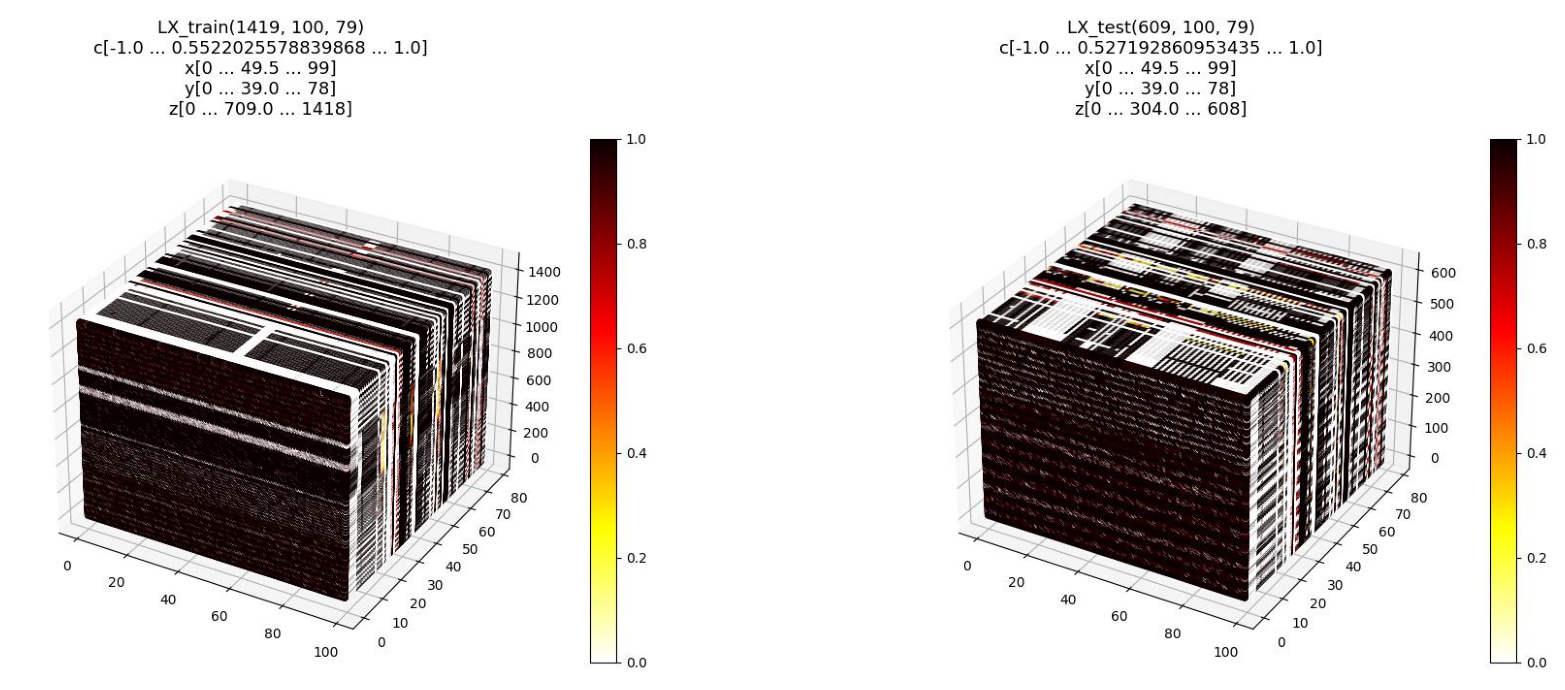

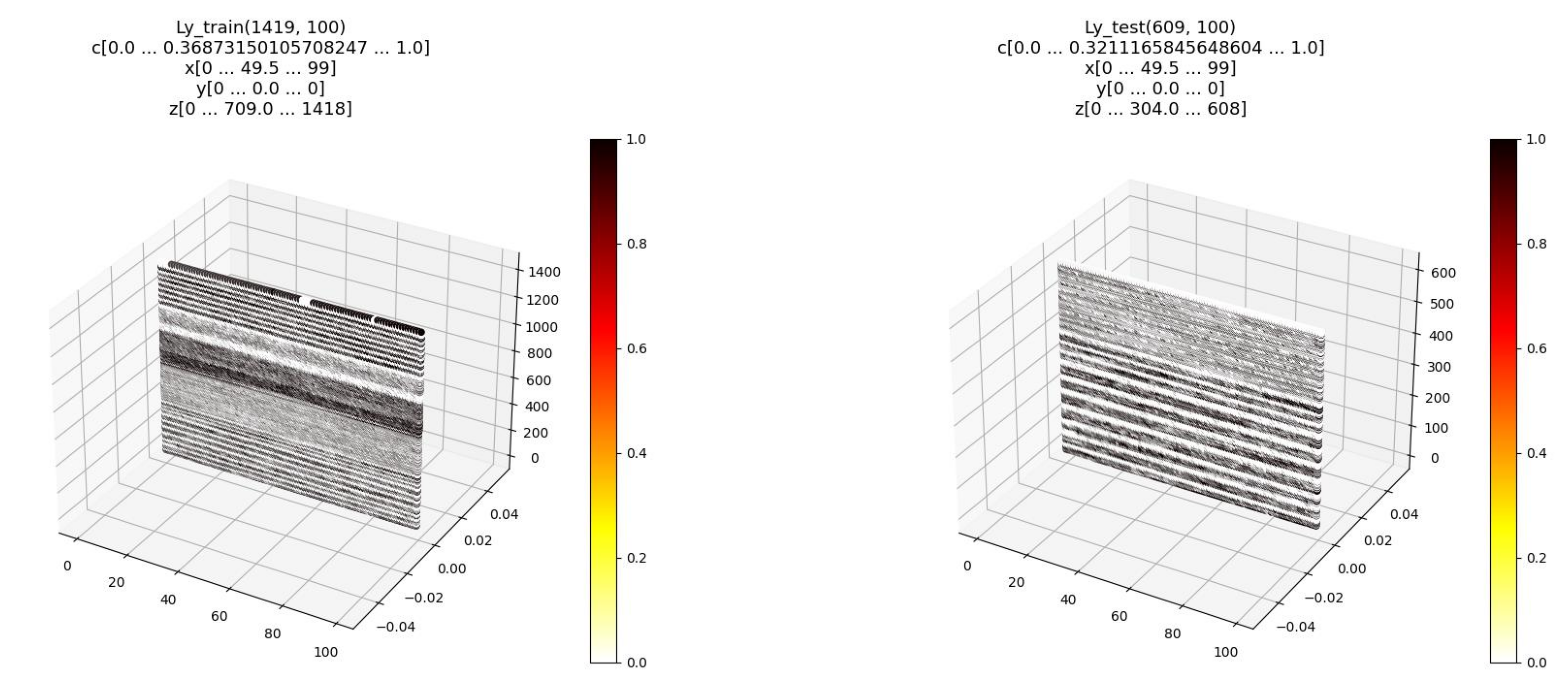

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_train','LX_test'])
show_4d_imgs(['Ly_train','Ly_test'])

# 4.INTRODUCTION

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.
To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

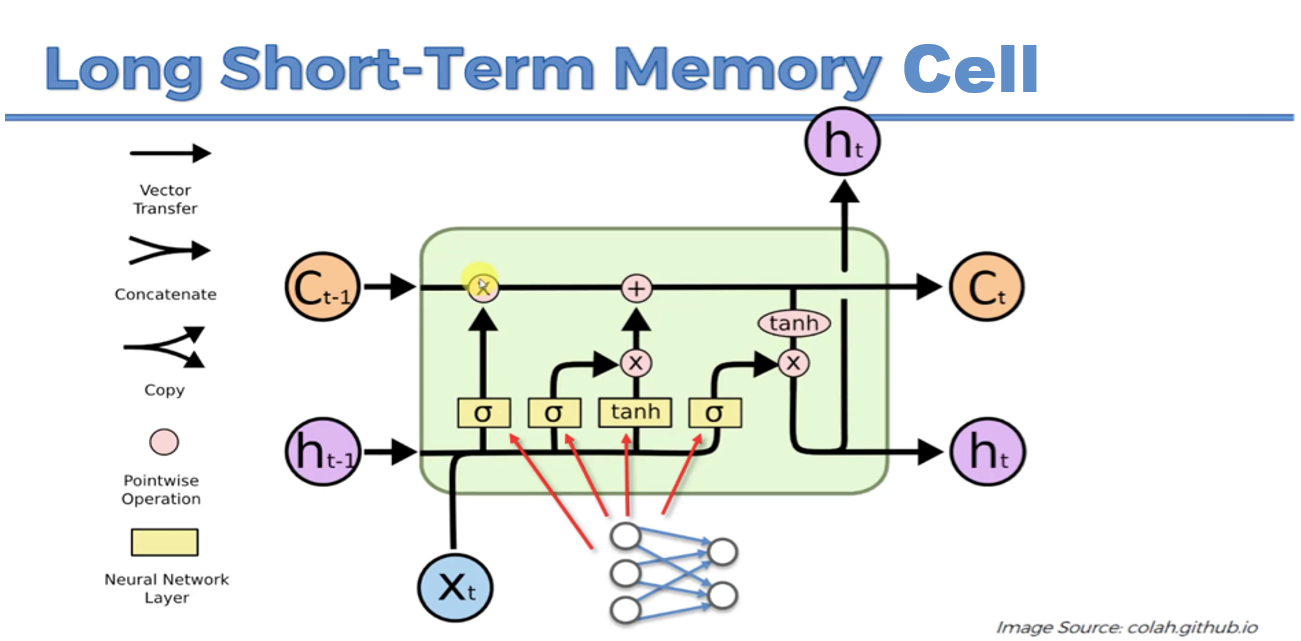

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

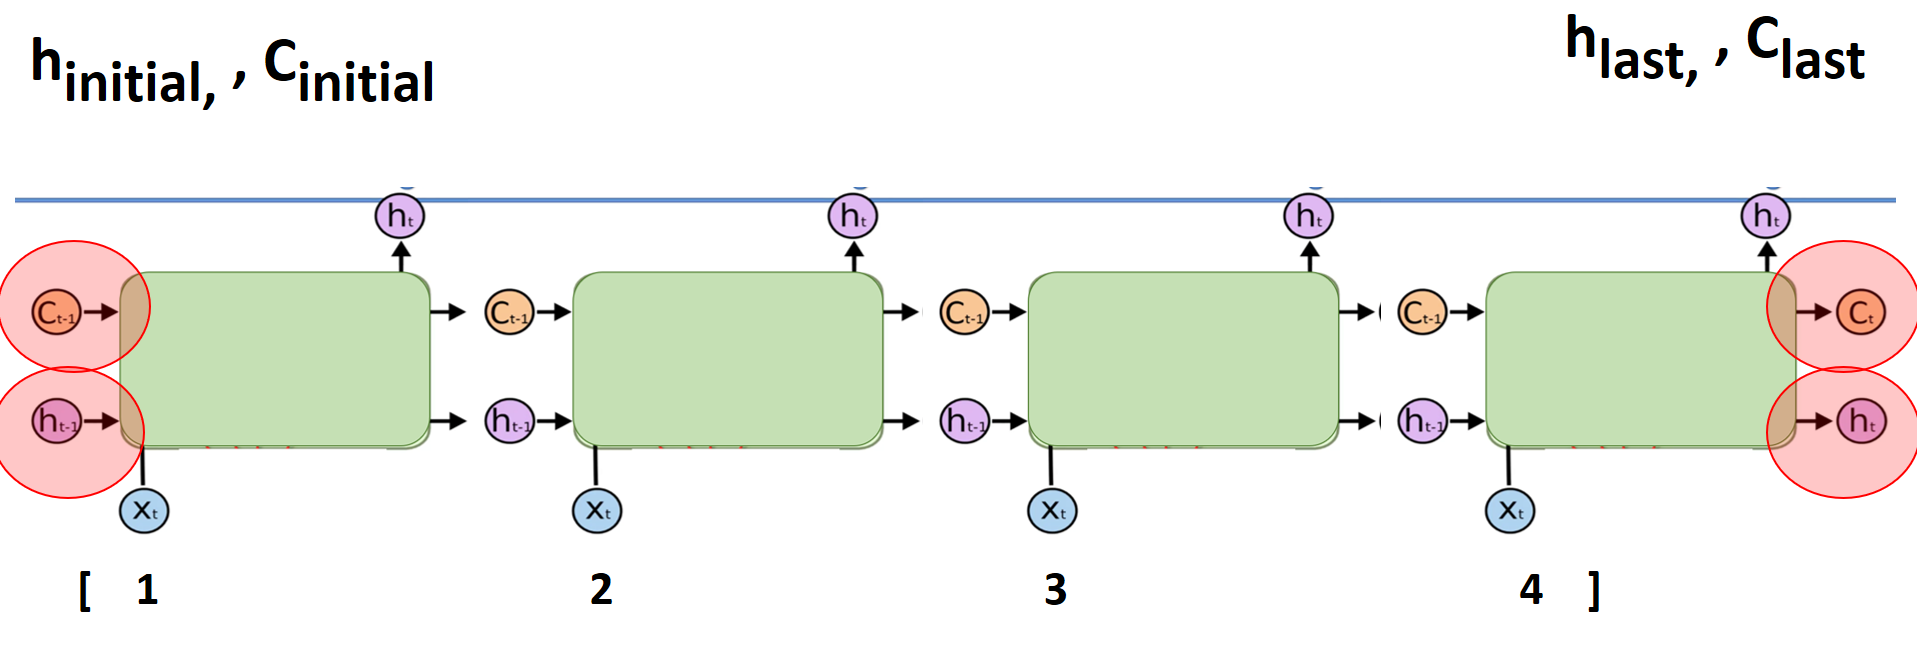

# 5.Train function

In [15]:
#@title train function

def train(model, name='model6'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  history = model.fit(LX_train, Ly_train, batch_size=batch_size, epochs=epochs, validation_data=(LX_test, Ly_test))
  show_train_metric(history, name)
  model.save(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  open(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}/features.json", "w").write(json.dumps(features))
  common.saving_checkpoint_to_mlflow(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")

In [24]:
#@title infer function
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
  model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
  ##############LX_train
  L_result1=model.predict(LX_train)
  train_predicted = np.vectorize(threshold)(L_result1)
  df_train_predicted = evaluate_checkpoint_metric('train_predicted', train_predicted.ravel(), Ly_train.ravel())

  ##############LX_test
  L_result2=model.predict(LX_test)
  test_predicted = np.vectorize(threshold)(L_result2)
  df_test_predicted = evaluate_checkpoint_metric('test_predicted', test_predicted.ravel(), Ly_test.ravel())
  

  IMG['Ly_train_predicted'], IMG['Ly_test_predicted'] = ray.get([
    show_scattered_4d.remote(L_result1, "Ly_train_predicted"),
    show_scattered_4d.remote(L_result2, "Ly_test_predicted"),
  ])
  print(df_train_predicted.to_string())
  show_4d_imgs(['LX_train','Ly_train','Ly_train_predicted'])
  print(df_test_predicted.to_string())
  show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])
  return pd.concat([df_train_predicted, df_test_predicted], axis=0, ignore_index=True)


___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [17]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=None, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

2023-03-20 12:10:39.442999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-20 12:10:39.443750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-20 12:10:39.444478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-03-20 12:10:39.445179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 79)]        0         
                                                                 
 dense1 (Dense)              (None, None, 230)         18400     
                                                                 
 lstm (LSTM)                 [(None, None, 320),       705280    
                              (None, 320),                       
                              (None, 320)]                       
                                                                 
 values (Dense)              (None, None, 1)           321       
                                                                 
Total params: 724,001
Trainable params: 724,001
Non-trainable params: 0
_________________________________________________________________


## 6.2.Train



Epoch 1/110


2023-03-20 12:10:42.418467: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-20 12:10:43.307857: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


45/45 [==============================] - 5s 29ms/step - loss: 0.3231 - accuracy: 0.8612 - val_loss: 0.1099 - val_accuracy: 0.9661
Epoch 2/110
45/45 [==============================] - 1s 18ms/step - loss: 0.1117 - accuracy: 0.9737 - val_loss: 0.0392 - val_accuracy: 0.9925
Epoch 3/110
45/45 [==============================] - 1s 18ms/step - loss: 0.0582 - accuracy: 0.9892 - val_loss: 0.0371 - val_accuracy: 0.9916
Epoch 4/110
45/45 [==============================] - 1s 18ms/step - loss: 0.0462 - accuracy: 0.9896 - val_loss: 0.0240 - val_accuracy: 0.9943
Epoch 5/110
45/45 [==============================] - 1s 19ms/step - loss: 0.0349 - accuracy: 0.9907 - val_loss: 0.0216 - val_accuracy: 0.9939
Epoch 6/110
45/45 [==============================] - 1s 18ms/step - loss: 0.0430 - accuracy: 0.9902 - val_loss: 0.0231 - val_accuracy: 0.9944
Epoch 7/110
45/45 [==============================] - 1s 18ms/step - loss: 0.0312 - accuracy: 0.9913 - val_loss: 0.0229 - val_accuracy: 0.9937
Epoch 8/110
45/45 

2023-03-20 12:12:14.338891: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/usr/local/lib/python3.7/dist-packages/mlflow/keras.py:406: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input.
  "The pyfunc inference behavior of Keras models logged "
/usr/local/lib/python3.7/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Ano

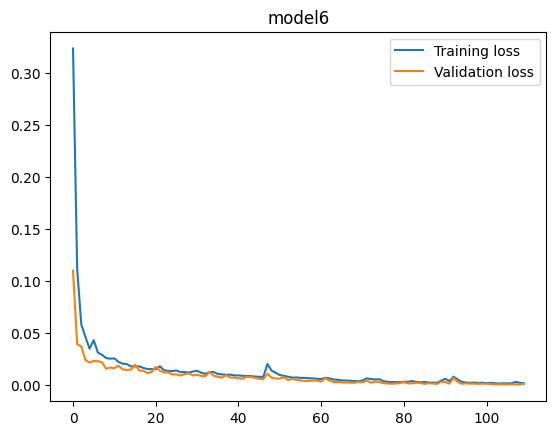

In [18]:
train(model6)

## 6.3.Infer



        checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  train_predicted             52308                 15            89555                22    141863         37       0.999739        0.000261


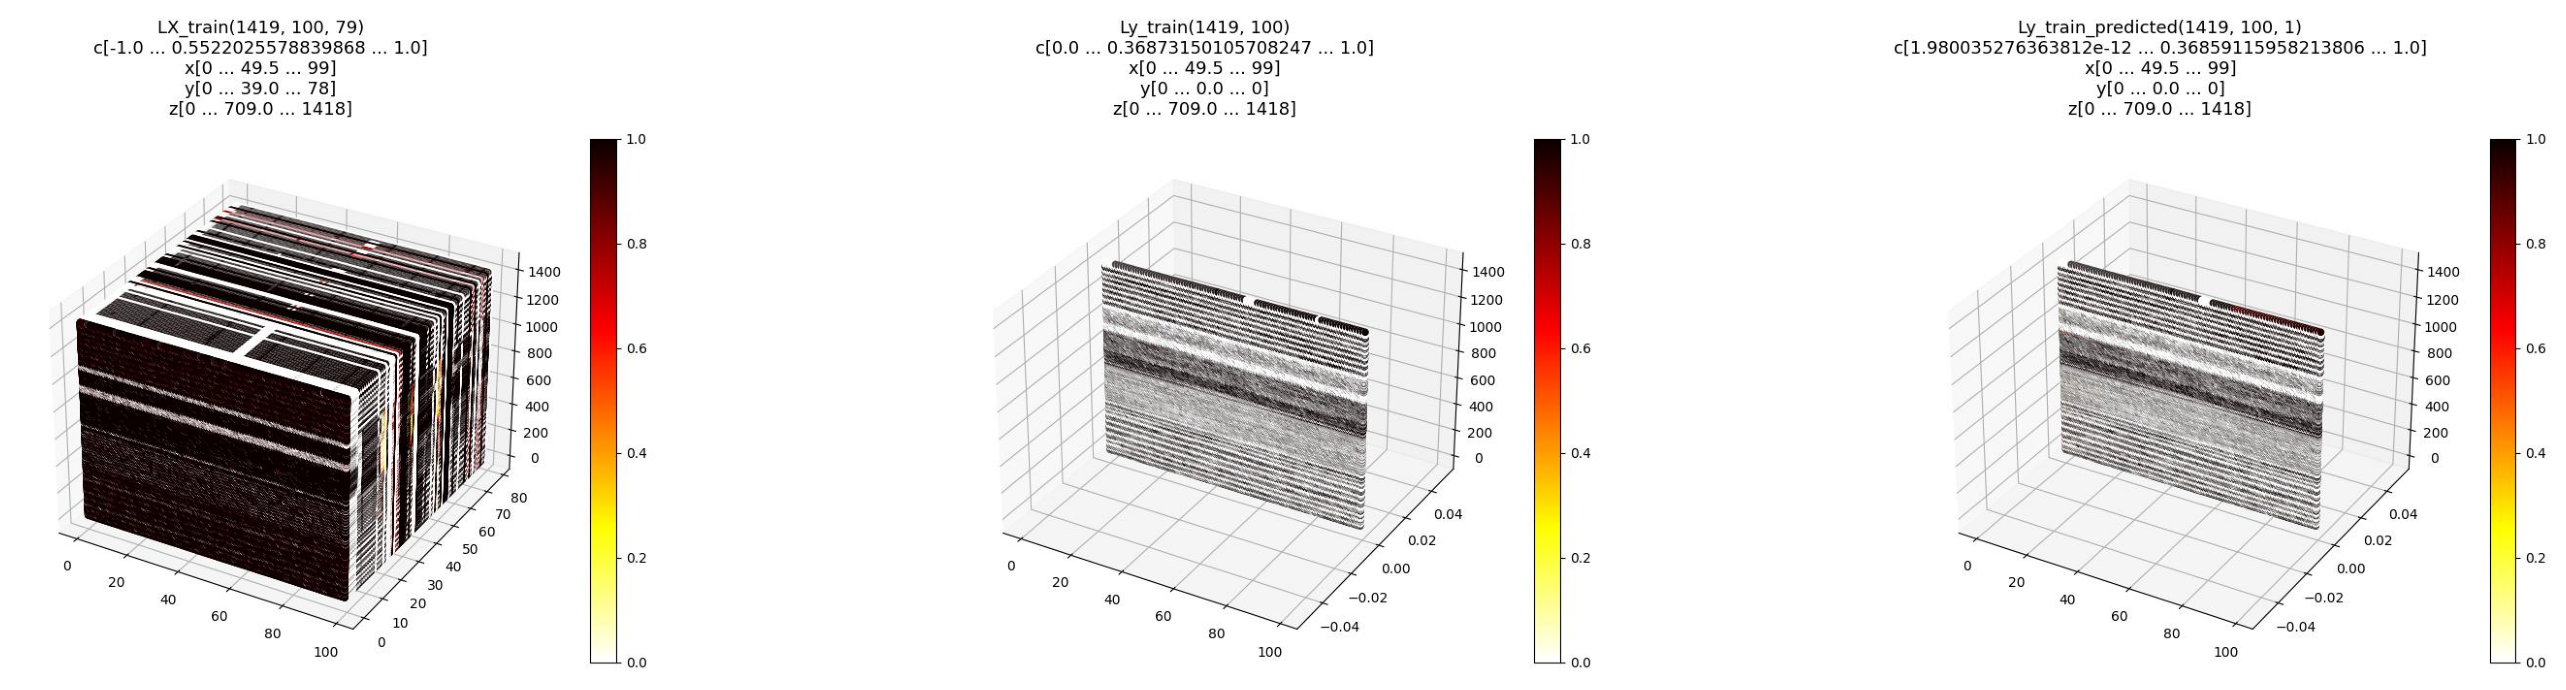

       checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  test_predicted             19553                  3            41336                 8     60889         11       0.999819        0.000181


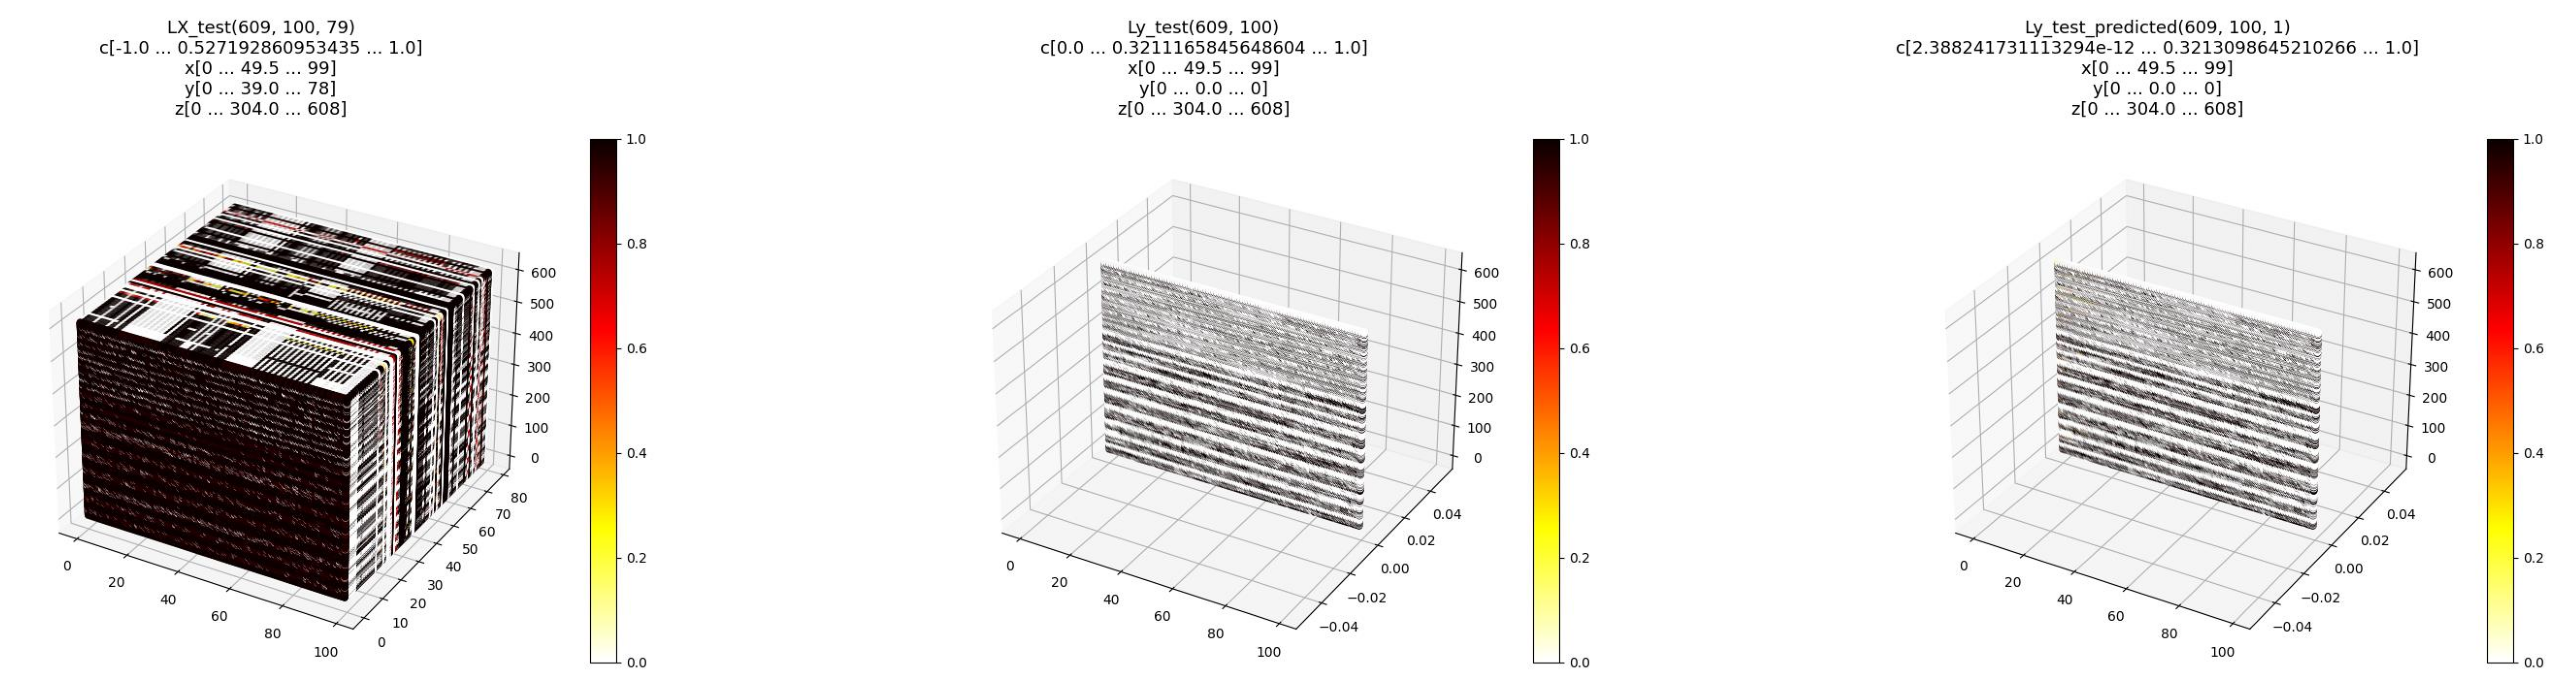

checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  \
0  train_predicted             52308                 15            89555   
1   test_predicted             19553                  3            41336   

   benign_incorrect  detected  incorrect  detected_rate  incorrect_rate  
0                22    141863         37       0.999739        0.000261  
1                 8     60889         11       0.999819        0.000181

In [25]:
df = infer_by_checkpoint(checkpoint)
df

# 7.MODEL WEIGHTS SUMMARY

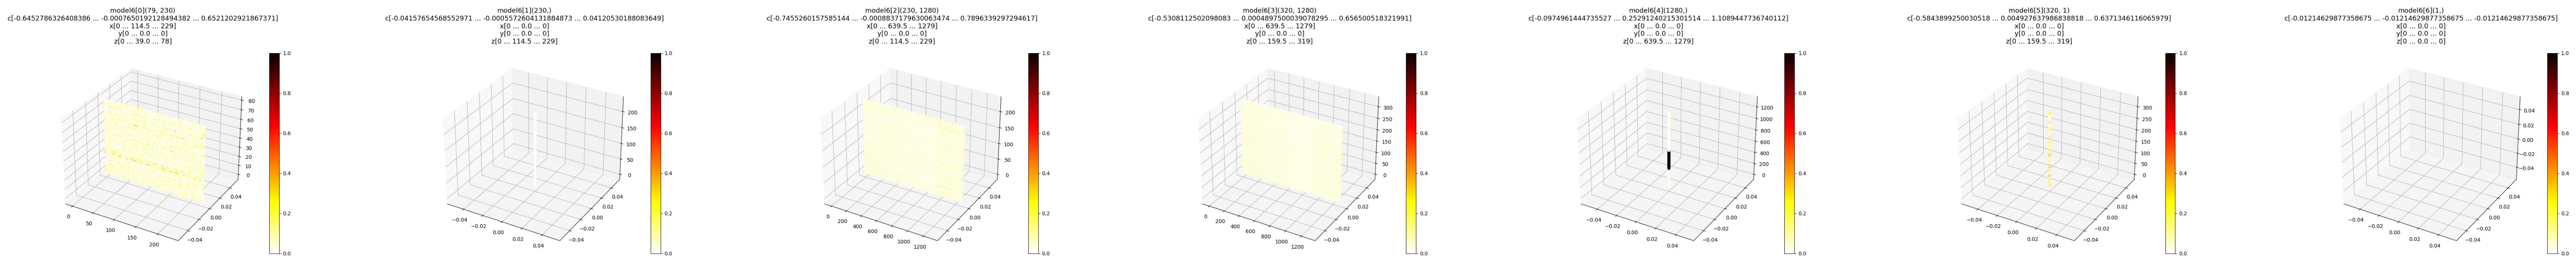

In [20]:
weights6 = show_weights(model6, 'model6')
show_4d_imgs(weights6)